# Setup

In [1]:
from datetime import datetime

now = datetime.now()
today_str = now.date().strftime('%m-%d-%Y')

In [2]:
import os
import scipy
import time
import random
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sklearn.cluster import HDBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
import matplotlib.pyplot as plt
import pickle
from fubon_neo.sdk import FubonSDK

# plt.rcParams['font.sans-serif'] = ['NotoSansSC-Regular']  # Set font
plt.rcParams['axes.unicode_minus'] = False    # Solve the problem that the minus sign '-' cannot be displayed

### 使用富邦新一代API做為行情源, doc: https://www.fbs.com.tw/TradeAPI/docs/trading/introduction

Load credential data from .env file, where

ID=身分字號 <br>
CERTPATH=憑證路徑 <br>
TRADEPASS=交易密碼 <br>
CERTPASS=憑證密碼 <br>

In [ ]:
load_dotenv()
ID = os.getenv('ID')
CERTPATH = os.getenv('CERTPATH')
TRADEPASS = os.getenv('TRADEPASS')
CERTPASS = os.getenv('CERTPASS')

# Connect and login
sdk = FubonSDK()
accounts = sdk.login(ID, TRADEPASS, CERTPATH, CERTPASS)
print(f"Login accounts:\n{accounts}\n")

sdk.init_realtime()  # 建立行情連線

# Marketdata client
client = sdk.marketdata.rest_client
session = client.stock

## Stock List

In [4]:
stocks = session.intraday.tickers(type='EQUITY', exchange="TWSE", isNormal=True)['data']
stocks = [stock for stock in stocks if not stock['symbol'].startswith(('A'))]

print(f'Total number of stocks {len(stocks)}')

Total number of stocks 1219


#### ***TODO***: Make database can work with threading

In [5]:
import sqlite3
import pandas as pd
from datetime import datetime, timezone

# db_path = 'stock_data.db'
# conn = sqlite3.connect(db_path, check_same_thread=False)

# cursor = conn.cursor()
        
# # Create a table for storing stock data if it does not exist
# cursor.execute('''
# CREATE TABLE IF NOT EXISTS stock_data (
#     symbol TEXT,
#     date TEXT,
#     open REAL,
#     high REAL,
#     low REAL,
#     close REAL,
#     volume INTEGER,
#     PRIMARY KEY (symbol, date)
# )
# ''')
# conn.commit()

def get_stock_data(symbol, session, db_path=None, retry=0):
    # global conn
    
    # # Connect to the SQLite database (it will be created if it does not exist)
    # if (db_path is not None) and (conn is not None) and (conn.closed) == 0:
    #     conn = sqlite3.connect(db_path)
    #     cursor = conn.cursor()
        
    #     # Create a table for storing stock data if it does not exist
    #     cursor.execute('''
    #     CREATE TABLE IF NOT EXISTS stock_data (
    #         symbol TEXT,
    #         date TEXT,
    #         open REAL,
    #         high REAL,
    #         low REAL,
    #         close REAL,
    #         volume INTEGER,
    #         PRIMARY KEY (symbol, date)
    #     )
    #     ''')
    #     conn.commit()
    # else:
    #     cursor = conn.cursor()
    
    # # Check if the data for the requested symbol already exists in the database
    # cursor.execute('SELECT MAX(date) FROM stock_data WHERE symbol = ?', (symbol,))
    # max_date = cursor.fetchone()[0]
    
    # if max_date is not None:
    #     # If data exists, compare the dates
    #     max_date = datetime.strptime(max_date, '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
    #     current_date = datetime.now(timezone.utc)
        
    #     if max_date.date() == current_date.date():
    #         # If the dates match, retrieve data from the database
    #         df = pd.read_sql_query('SELECT * FROM stock_data WHERE symbol = ?', conn, params=(symbol,), parse_dates=['date'])
    #         df.set_index('date', inplace=True)
    #         df.index = df.index.tz_localize('UTC').tz_convert('Asia/Taipei')  # Adjust the timezone to your specific case
    #         return df
    
    # If the dates do not match or no data exists, download the data
    try:
        data = session.historical.candles(**{'symbol': symbol, 'timeframe': '5'})['data']
    except KeyError as e:
        if retry < 5:
            time.sleep(5)
            return get_stock_data(symbol, session, retry=retry+1)
        else:
            # print(f"No data for {symbol}")
            return None
        
    df = pd.DataFrame(data)
    try:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(ascending=True, inplace=True)
    except KeyError as e:
        print(f"symbol: {symbol}, data {data}, error {e}")
        return None
    
    # # Store the downloaded data in the database
    # df_reset = df.reset_index()
    # df_reset['symbol'] = symbol
    # # Convert datetime to string without timezone info before storing in SQLite
    # df_reset['date'] = df_reset['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
    # df_reset.to_sql('stock_data', conn, if_exists='replace', index=False)

    # if db_path is not None:
    #     conn.close()
        
    return df

## Functions

In [6]:
def get_turning_points(close_prices):
    # Auxiliary function
    def find_middle_idx(start, end):
        """Given a start and end index, return the middle index. For even lengths, return the earlier middle."""
        return start + (end - start) // 2

    # Initialize lists to store the indices of high and low points
    high_points = []
    low_points = []
    
    # Iterate over the close price series
    n = len(close_prices)
    i = 1
    
    while i < n - 1:
        if close_prices[i] > close_prices[i - 1]:  # Potential peak
            start = i
    
            # Find end of plateau
            while i < n - 1 and close_prices[i] == close_prices[i + 1]:
                i += 1
            end = i
    
            # If it's indeed a peak, add the middle point
            if i < n - 1 and close_prices[i] > close_prices[i + 1]:
                high_points.append(find_middle_idx(start, end))
    
        elif close_prices[i] < close_prices[i - 1]:  # Potential trough
            start = i
    
            # Find end of plateau
            while i < n - 1 and close_prices[i] == close_prices[i + 1]:
                i += 1
            end = i
    
            # If it's indeed a trough, add the middle point
            if i < n - 1 and close_prices[i] < close_prices[i + 1]:
                low_points.append(find_middle_idx(start, end))
    
        i += 1
    
    # Convert lists to numpy arrays
    high_points = np.array(high_points)
    low_points = np.array(low_points)

    return high_points, low_points

In [7]:
def smooth_cluster_assignments(labels, window_size=3):
    """
    Refine the cluster assignments by considering the neighborhood of each point.
    
    Parameters:
    - labels: ndarray, The initial cluster assignments.
    - window_size: int, The size of the window around each point.
    
    Returns:
    - refined_labels: ndarray, The refined cluster assignments.
    """
    refined_labels = labels.copy()
    
    for i, label in enumerate(labels):
        if label == -1:
            continue
        
        start_idx = max(0, i - window_size)
        end_idx = min(len(labels), i + window_size + 1)
        
        neighbor_labels = labels[start_idx:end_idx]
        valid_neighbor_labels = neighbor_labels[neighbor_labels != -1]
        
        if len(valid_neighbor_labels) == 0:
            continue
        
        most_common_label = np.bincount(valid_neighbor_labels).argmax()
        
        if most_common_label != label:
            refined_labels[i] = most_common_label
    
    return refined_labels

In [8]:
def HDBSCAN_clustering(close_prices, high_points, low_points, smooth=True, smooth_window_size=3, min_cluster_size=6):
    # Aggregation
    turning_points = np.concatenate((high_points, low_points))
    turning_points.sort()

    if len(turning_points) < max(5, min_cluster_size):  # Data not enough
        return None
    
    # Get the last close price and its index (time)
    last_close_price = close_prices[-1]
    last_time_index = len(close_prices) - 1
    
    # Compute vertical (log-scaled price difference) and horizontal (time difference) distances
    vertical_distances = np.abs(np.log(close_prices[turning_points]) - np.log(last_close_price))
    horizontal_distances = np.abs(turning_points - last_time_index)
    
        
    # Combine weighted features into a 2D array
    features = np.column_stack((vertical_distances, horizontal_distances))
    
    # Normalize the features
    scaler = MinMaxScaler()
    # scaler = RobustScaler()
    # scaler = MaxAbsScaler()
    features_normalized = scaler.fit_transform(features)

    # Define the weights
    vertical_weight = 0.6
    horizontal_weight = 0.4
    
    # Apply weights to the features
    weighted_features = features_normalized * np.array([vertical_weight, horizontal_weight])
    
    # Apply HDBSCAN Clustering
    dbscan = HDBSCAN(min_cluster_size=min_cluster_size)
    labels = dbscan.fit_predict(weighted_features)
    
    if smooth:
        labels = smooth_cluster_assignments(labels, window_size=smooth_window_size)
        # # ### Cluster data cleaning
        # window_size = clean_window_size
    
        # # Iterate over each turning point and its cluster assignment
        # for i, label in enumerate(labels):
        #     # Ignore noise
        #     if label == -1:
        #         continue
            
        #     # Determine the start and end index of the window around the current point
        #     start_idx = max(0, i - window_size)
        #     end_idx = min(len(close_prices), i + window_size + 1)
            
        #     # Get the labels of the neighboring points within the window
        #     neighbor_labels = labels[start_idx:end_idx]
            
        #     # Filter out noise label (-1) before calculating the most common label
        #     valid_neighbor_labels = neighbor_labels[neighbor_labels != -1]
            
        #     # If all neighbor labels are noise, continue to the next iteration
        #     if len(valid_neighbor_labels) == 0:
        #         continue
            
        #     # Find the most common label in the neighborhood, excluding the label of the current point
        #     most_common_label = np.bincount(valid_neighbor_labels).argmax()
            
        #     # If the most common label in the neighborhood is different from the current label, reassign the point
        #     if most_common_label != label:
        #         labels[i] = most_common_label
        # # ###

    return labels

In [9]:
def plot_clusters(close_prices, turning_points, labels):
    plt.figure(figsize=(10, 6))
    
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Find the number of clusters (ignoring noise if present)  
    
    for i in range(num_clusters):
        idx = np.where(labels == i)
        plt.scatter(turning_points[idx], close_prices[turning_points[idx]], label=f'Cluster {i}', marker='o')
    if -1 in labels:
        idx = np.where(labels == -1)
        plt.scatter(turning_points[idx], close_prices[turning_points[idx]], label='Noise', marker='x')
    
    # Plotting the 'close' column
    plt.plot(range(len(close_prices)), close_prices, label='Close Prices', color='gray', alpha=0.3)
    
    plt.legend()
    plt.show()

In [10]:
def compute_peak_prices(close_prices, high_points, low_points, cluster_indices, percentile_cutoff=90):
    # Initialize dictionaries for peak_prices, weights, kde, market_profiles
    peak_prices = {}
    weights = {}
    kde = {}
    market_profiles = {}
    price_range = {}

    turning_points = np.concatenate((high_points, low_points))
    turning_points.sort()
    
    # # Define a function to calculate weights
    # def cal_weights(series):
    #     initial_weight = 1
    #     final_weight = 1
    #     step = (final_weight - initial_weight) / len(series)
    #     weights = initial_weight + np.arange(len(series)) * step
    #     weights[weights < 0] = 0
    #     return weights
    
    # Iterate for high and low points
    for key in ['high', 'low']:
        points = high_points if key == 'high' else low_points

        # Extract log of close prices corresponding to points in the cluster
        group_points = turning_points[cluster_indices][np.isin(turning_points[cluster_indices], points)]
        close_log = np.log(close_prices[group_points])

        if len(close_log) == 0:  # Failed to find corresponding turning points
            peak_prices[key] = None
        else:
            percentile = percentile_cutoff if key == 'high' else 100 - percentile_cutoff
            peak_prices[key] = [np.exp(np.percentile(close_log, percentile))] 
        
    return peak_prices

## Screener

In [11]:
import sys

def is_valid_cluster(close_prices, high_points, low_points, labels, peak_prices_dict, verbose=False):
    """
    Validates the most recent cluster based on the conditions provided.
    
    Parameters:
    - close_prices: ndarray, Array of close prices.
    - turning_points: ndarray, Array of turning points (indices).
    - labels: ndarray, Array of cluster labels.
    - peak_prices_dict: dict, Dictionary of peak prices for clusters.
    
    Returns:
    - bool, True if the conditions are met, False otherwise.
    """

    turning_points = np.concatenate((high_points, low_points))
    turning_points.sort()
    
    # Check if the recent close price is at a high level
    price_max = np.max(close_prices)
    price_min = np.min(close_prices)
    if price_max == price_min:
        if verbose:
            print(f'No meaningful price range. price_max {price_max}, price_min {price_min}')
        return False
    price_ratio =  (close_prices[-1] - price_min) / (price_max - price_min)

    ratio_threshold = 0.6
    
    if price_ratio > ratio_threshold:
        if verbose:
            print(f'The recent close price is too high. Ratio {price_ratio}, cutoff {ratio_threshold}')
        return False
    
    # Find the most recent cluster
    end_time_store = 0
    recent_cluster_label = -1
    
    for cluster_label, peak_prices in peak_prices_dict.items():
        # Find the time-span of the data points in the same group
        cluster_indices = np.where(labels == cluster_label)[0]
        start_time = turning_points[cluster_indices].min()
        end_time = turning_points[cluster_indices].max()

        if end_time > end_time_store:
            end_time_store = end_time
            recent_cluster_label = cluster_label

    if recent_cluster_label == -1:
        if verbose:
            print(f'No valid cluster, recent_cluster_label {recent_cluster_label}')
        return False

    # Filter 1 - The support and resistence levels have good fitness (r-square)
    high_points_cluster = [x for x in turning_points[cluster_indices] if x in high_points]
    low_points_cluster = [x for x in turning_points[cluster_indices] if x in high_points]
    high_prices_cluster = close_prices[high_points_cluster]
    low_prices_cluster = close_prices[low_points_cluster]

    if len(high_prices_cluster) < 2 or len(low_prices_cluster) < 2:
        if verbose:
            print(f'Not enough pivot points. #high {len(high_prices_cluster)}, #low {len(low_prices_cluster)}')
        return False

    sl_lows, interc_lows, r_value_l, _, _ = scipy.stats.linregress(low_points_cluster, low_prices_cluster)
    sl_highs, interc_highs, r_value_h, _, _ = scipy.stats.linregress(high_points_cluster, high_prices_cluster)

    r_square_threshold = 0.2
    
    if (r_value_l**2 < r_square_threshold) or (r_value_h**2 < r_square_threshold):
        if verbose:
            print(f'Fitness is not enough. R2_l {r_value_l**2}, R2_h {r_value_h**2}, threshold {r_square_threshold}')
        return False

    # Filter 2 - The support and resistence levels have good fitness (slope degree)
    angle_high = np.arctan(sl_highs) * 180 / np.pi
    angle_low = np.arctan(sl_lows) * 180 / np.pi

    cutoff_degrees = 30

    if (abs(angle_high) > cutoff_degrees) or (abs(angle_low) > cutoff_degrees):
        if verbose:
            print(f'Reg line slope too steep. angle_high {angle_high}, angle_low {angle_low}, cutoff_degrees {cutoff_degrees}')
        return False
    
    # 1. Check if the last close data point is in the cluster or close to it
    cluster_indices = np.where(labels == recent_cluster_label)[0]
    if len(close_prices) - turning_points[cluster_indices][-1] > 12:
        if verbose:
            print(f'Last price is far away from the last cluster')
        return False
    
    # 2. Ensure the time span of this cluster doesn't overlap with others
    for label in set(labels):
        if label == -1:
            continue
            
        if label != recent_cluster_label:
            other_cluster_indices = np.where(labels == label)[0]
            if turning_points[cluster_indices].max() > turning_points[other_cluster_indices].min() and turning_points[cluster_indices].min() < turning_points[other_cluster_indices].max():
                if verbose:
                    print(f'Timespan overlapped')
                return False
    
    # Extract the recent cluster's peak prices
    recent_peak_prices = peak_prices_dict.get(recent_cluster_label, {})
    if recent_peak_prices.get("high", None) is None or recent_peak_prices.get("low", None) is None:
        if verbose:
            print(f'Peak price range does not exist. recent_peak_prices {recent_peak_prices}')
        return False

    try:
        high_price = recent_peak_prices.get('high', [None])[0]
        low_price = recent_peak_prices.get('low', [None])[0]
    except TypeError as e:
        print(f'Error {e}')
        print(f'recent_peak_prices {recent_peak_prices}')
        print(f'get high {recent_peak_prices.get("high", [None])}')
        print(f'get low {recent_peak_prices.get("low", [None])}')
        sys.exit(1)
    
    # 3. Ensure the last close price is within the peak price range
    if high_price is None or low_price is None or not low_price <= close_prices[-1] <= high_price:
        if verbose:
            print(f'The close price is not in the range. Close {close_prices[-1]}, high {high_price}, low {low_price}')
        return False
    
    # 4. Check the log distance conditions for close prices within the cluster
    lowest_close_within_cluster = close_prices[turning_points[cluster_indices]].min()
    if np.abs(np.log(lowest_close_within_cluster) - np.log(low_price)) < 0.1 * np.abs(np.log(high_price) - np.log(low_price)):
        if verbose:
            print(f'Dive is not significant enough.')
        return False    
    
    # All conditions met
    return True

## Main Loop

In [12]:
# l = [
#     {'symbol': '1789', 'name': ''},
#     {'symbol': '9904', 'name': ''},
#     {'symbol': '2535', 'name': ''},
#     {'symbol': '1307', 'name': ''},
# ]

In [13]:
result_summary = None

file_name = f'intraday_screener_results_{today_str}_v2.pkl'
if os.path.isfile(file_name):
    with open(file_name, 'rb') as file:
        result_summary = pickle.load(file)

In [ ]:
import threading

verbose = False
random.shuffle(stocks)
# stocks = l

count = 0
count_success = 0

if ('result_summary' in locals() or 'result_summary' in globals()) and result_summary is not None:
    results_list = result_summary['results']
else:
    results_list = []
    result_summary = {
        'stock_checked': [],
        'results': results_list, 
    }

# Threading processor
def threading_processor(stock):
    global count, count_success, results_list
    
    symbol = stock['symbol']
    name = stock['name']

    count += 1

    if symbol in result_summary['stock_checked']:
        if verbose:
            print(f'\t\t{symbol} {name} has been checked, pass')
        print(f'{symbol} {name} checked. count {count}, count_success {count_success}')
        return
        

    # print(f'{symbol} {name}', end="  ")
    
    # ### Retrieve data
    df = get_stock_data(symbol, session)
    if df is None:
        if verbose:
            print(f'\t\t{symbol} {name} has no data, pass')
        print(f'{symbol} {name} checked. count {count}, count_success {count_success}')
        return
    
    close_prices = df['close'].to_numpy()

    # ### Find turning points
    high_points, low_points = get_turning_points(close_prices)
    
    turning_points = np.concatenate((high_points, low_points))
    turning_points.sort()

    # ### Clustering
    labels = HDBSCAN_clustering(close_prices, high_points, low_points, smooth=True)
    if labels is None:
        if verbose:
            print(f'\t\t{symbol} {name} does not enough data, pass')
        print(f'{symbol} {name} checked. count {count}, count_success {count_success}')
        return
    
    # ### Find support and resistance levels
    peak_prices_dict = {}
    
    for cluster_label in set(labels):
        if cluster_label == -1:  # skip the noise cluster
            if verbose:
                print(f'\t\t{symbol} {name} cluster noise check failed, pass')
            print(f'{symbol} {name} checked. count {count}, count_success {count_success}')
            return
    
        # Indices of the turning points in the current cluster
        cluster_indices = np.where(labels == cluster_label)[0]
            
        # Compute peak prices for the current cluster
        peak_prices = compute_peak_prices(close_prices, high_points, low_points, cluster_indices)
        peak_prices_dict[cluster_label] = peak_prices

    # Screener 1
    condition1 = is_valid_cluster(close_prices, high_points, low_points, labels, peak_prices_dict, verbose=verbose)
    if verbose:
        print(f'\t\t{symbol} {name} is good one? {condition1}')

    if condition1:
        count_success += 1

        # Keep the result
        result = {
            'symbol': symbol, 
            'name': name, 
            'data': df,
            'stats': {
                'high_points':  high_points,
                'low_points': low_points,
                'labels': labels,
                'peak_prices_dict': peak_prices_dict,
            }
        }
        results_list.append(result)
        
        # # ### Plot the result ###################
        # plt.figure(figsize=(10, 6))
    
        # # Plot the turning points by their corresponding labels 
        # for i in set(labels):
        #     if i == -1:
        #         continue
        #     idx = np.where(labels == i)
        #     plt.scatter(turning_points[idx], close_prices[turning_points[idx]], label=f'Cluster {i}', marker='o')
        
        # # Handle noise points if present
        # if -1 in labels:
        #     idx = np.where(labels == -1)
        #     plt.scatter(turning_points[idx], close_prices[turning_points[idx]], label='Noise', marker='x')
        
        # # Plotting the 'close' column
        # plt.plot(range(len(close_prices)), close_prices, label='Close Prices', color='gray', alpha=0.3)
        
        # # Iterate through each cluster label and plot the peak prices as horizontal lines
        # for cluster_label, peak_prices in peak_prices_dict.items():
            # # Find the time-span of the data points in the same group
            # cluster_indices = np.where(labels == cluster_label)[0]
            # start_time = turning_points[cluster_indices].min()
            # end_time = turning_points[cluster_indices].max()
            
            # # Plot high peak prices as horizontal dashed lines
            # if peak_prices['high'] is not None and len(peak_prices['high']) > 0:
            #     for high_price in peak_prices['high']:
            #         plt.hlines(high_price, xmin=start_time, xmax=end_time, colors='r', linestyles='dashed', label=f'High Peak Cluster {cluster_label}')
            
            # # Plot low peak prices as horizontal dashed lines
            # if peak_prices['low'] is not None and len(peak_prices['low']) > 0:
            #     for low_price in peak_prices['low']:
            #         plt.hlines(low_price, xmin=start_time, xmax=end_time, colors='b', linestyles='dashed', label=f'Low Peak Cluster {cluster_label}')

        # # Setting y-axis to log scale
        # plt.yscale('log')
        
        # # Adjusting y-tick labels to show the original prices
        # y_vals = plt.gca().get_yticks()
        # plt.gca().set_yticks(y_vals)  # Set the tick locations
        # plt.gca().set_yticklabels(y_vals)

        # # Setting the y-axis display range
        # y_min = df['low'].min() * 0.99  # 1% below the minimum close value
        # y_max = df['high'].max() * 1.01  # 1% above the maximum close value
        # plt.ylim(y_min, y_max)
        
        # # plt.legend()
        # plt.title(f"{symbol}")
        # plt.show()
    
        # plt.close()
        # # ### Plot end ###################
        
    # print('\n========================= Divisor =========================\n')        
    
    # ### End the loop
    # if count_success > 10:
    #     break

    result_summary['stock_checked'].append(symbol)
    result_summary['results'] = results_list

    print(f'{symbol} {name} checked. count {count}, count_success {count_success}')

# Start running the scanner
threads = []

for stock in stocks:
    t = threading.Thread(target=threading_processor, args=(stock,))
    threads.append(t)
    t.start()

    if len(threads) > 10:
        for t in threads:
            t.join()

        threads = []

# Wait all threads to be complete
for t in threads:
    t.join()

# Open the file in write-binary mode and save the variable
with open(file_name, 'wb') as file:
    pickle.dump(result_summary, file)  

## Plot

In [17]:
len(result_summary['results'])

8

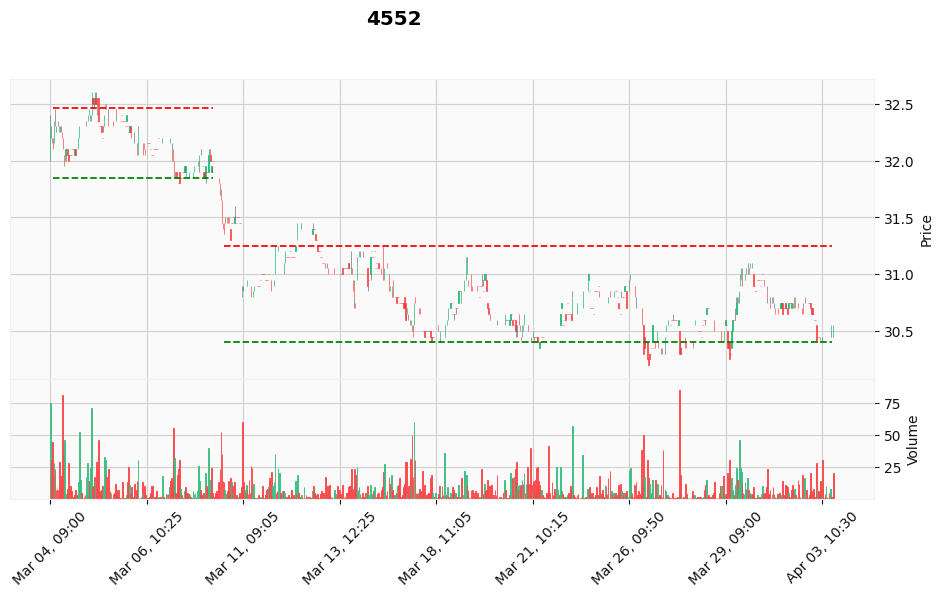

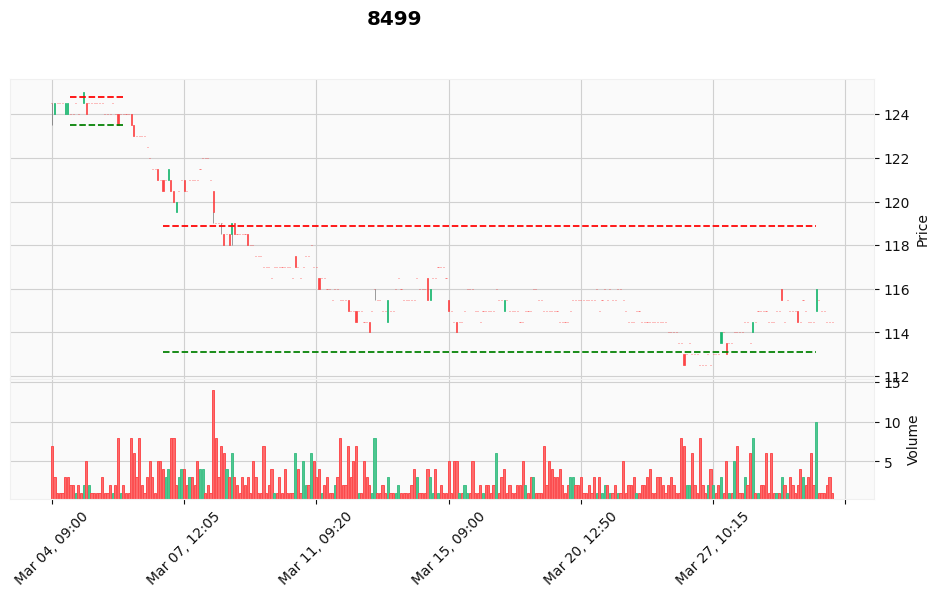

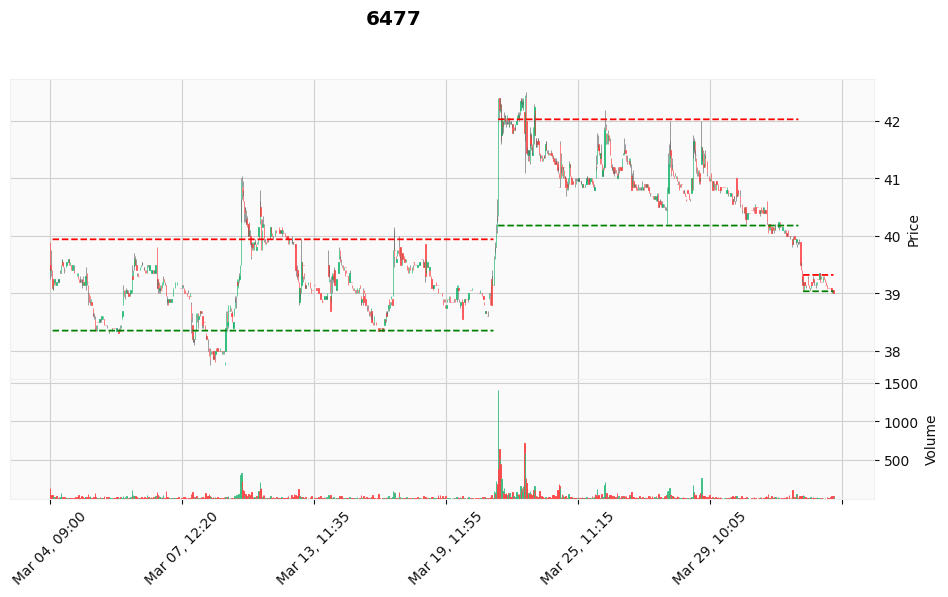

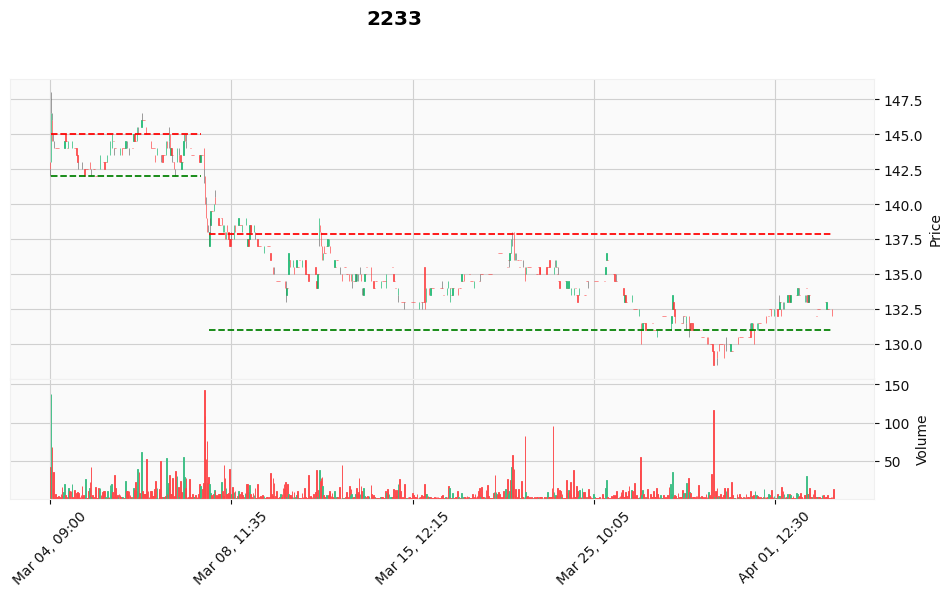

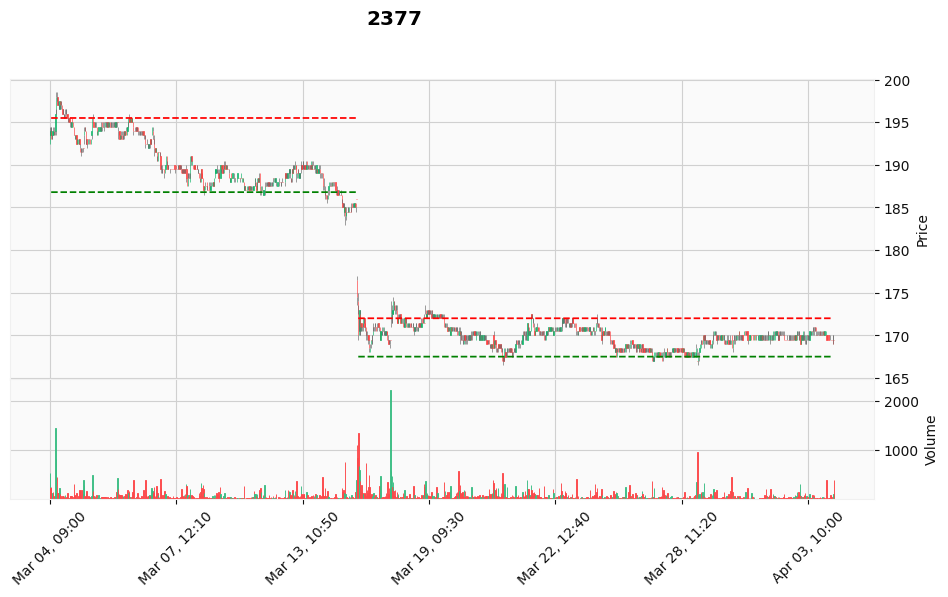

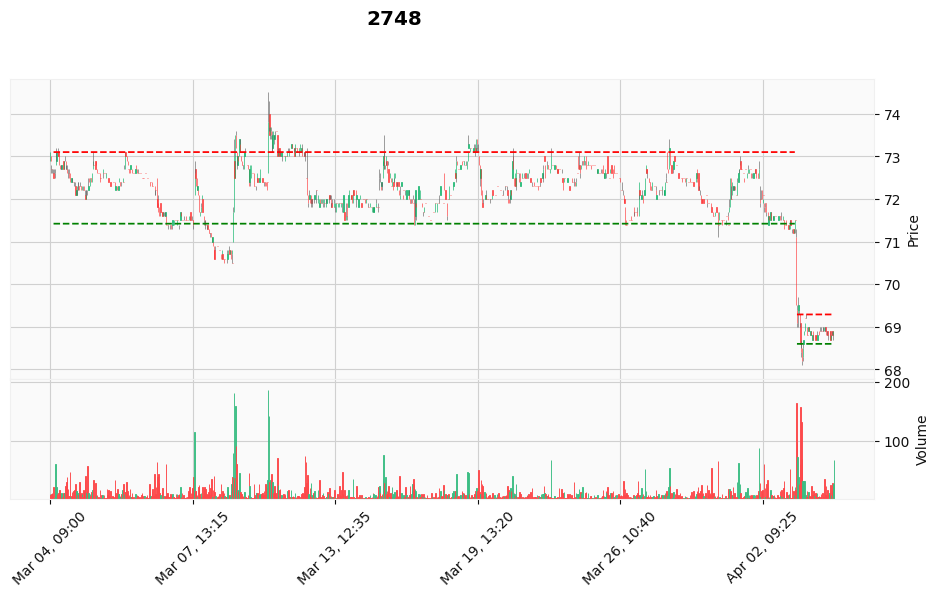

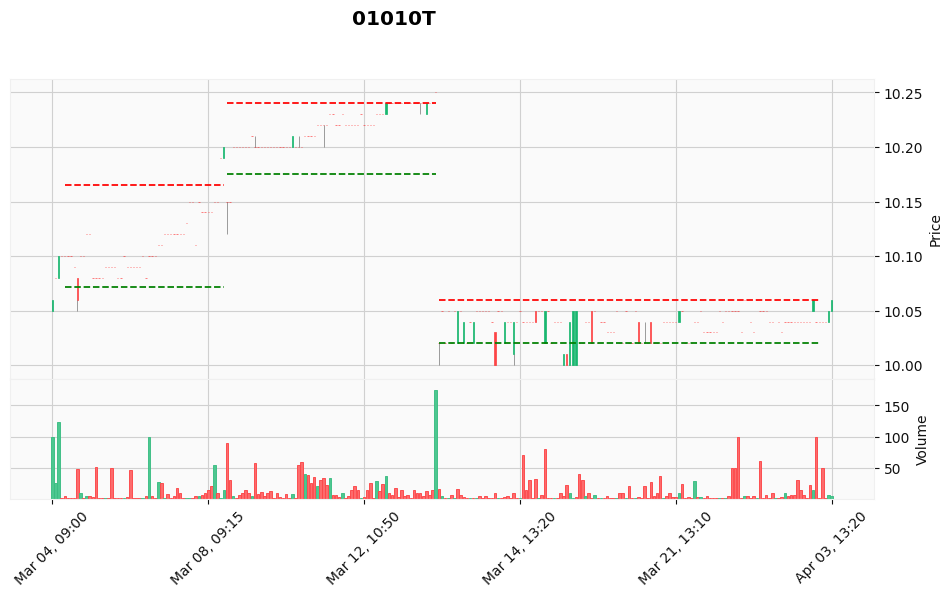

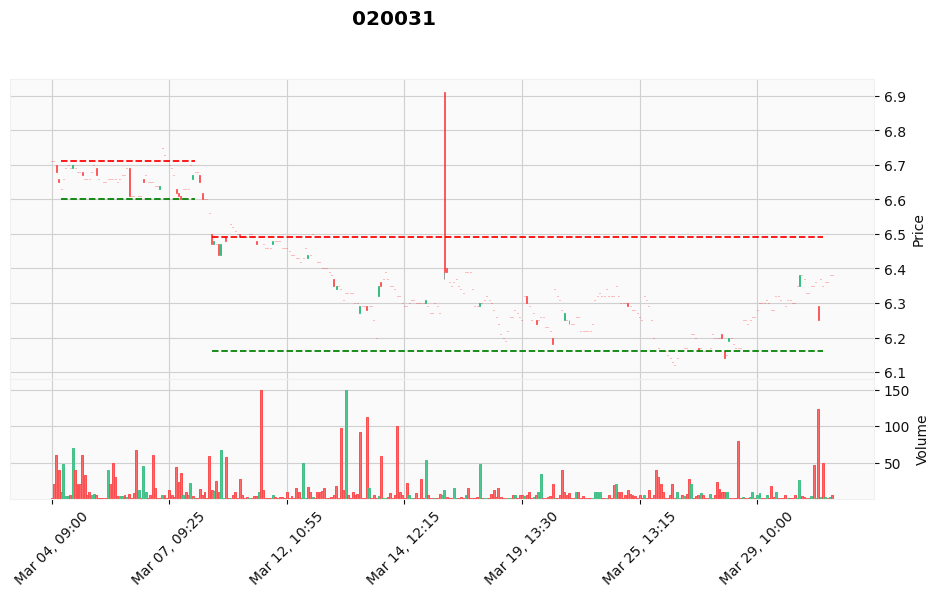

In [21]:
import mplfinance as mpf
import matplotlib.pyplot as plt

results = result_summary['results']

for item in results:
    symbol = item['symbol']
    name = item['name']
    df = item['data']
    stats = item['stats']

    labels = stats['labels']
    peak_prices_dict = stats['peak_prices_dict']
    high_points = stats['high_points']
    low_points = stats['low_points']

    turning_points = np.concatenate((high_points, low_points))
    turning_points.sort()

    title = f'{symbol}'

    # # Plot
    # additional_plots = []

    # # Iterate through cluster_labels and peak_prices
    # for cluster_label, peak_prices in peak_prices_dict.items():
    #     # Find the time-span of the data points in the same group
    #     cluster_indices = np.where(labels == cluster_label)[0]
    #     start_time = turning_points[cluster_indices].min()
    #     end_time = turning_points[cluster_indices].max()
        
    #     # Add high peak prices as horizontal dashed lines
    #     if peak_prices['high'] is not None:
    #         for high_price in peak_prices['high']:
    #             data_plot = []
    #             for i in range(len(df.index)):
    #                 if start_time <= i <= end_time:
    #                     data_plot.append(high_price)
    #                 else:
    #                     data_plot.append(np.nan)
    #             additional_plots.append(mpf.make_addplot(data_plot, type='line', color='r', linestyle='dashed'))
        
    #     # Add low peak prices as horizontal dashed lines
    #     if peak_prices['low'] is not None:
    #         for low_price in peak_prices['low']:
    #             data_plot = []
    #             for i in range(len(df.index)):
    #                 if start_time <= i <= end_time:
    #                     data_plot.append(low_price)
    #                 else:
    #                     data_plot.append(np.nan)
    #             additional_plots.append(mpf.make_addplot(data_plot, type='line', color='g', linestyle='dashed'))

    # Initialize the list for additional plots
    additional_plots = []
    
    # Iterate through cluster_labels and peak_prices
    for cluster_label, peak_prices in peak_prices_dict.items():
        # Find the time-span of the data points in the same group
        cluster_indices = np.where(labels == cluster_label)[0]
        start_time = turning_points[cluster_indices].min()
        end_time = turning_points[cluster_indices].max()
        
        # Define a function to create data plots
        def create_data_plot(price):
            return [price if start_time <= i <= end_time else np.nan for i in range(len(df.index))]
        
        # Add high peak prices as horizontal dashed lines
        if peak_prices['high'] is not None:
            for high_price in peak_prices['high']:
                additional_plots.append(mpf.make_addplot(create_data_plot(high_price), type='line', color='r', linestyle='dashed'))
        
        # Add low peak prices as horizontal dashed lines
        if peak_prices['low'] is not None:
            for low_price in peak_prices['low']:
                additional_plots.append(mpf.make_addplot(create_data_plot(low_price), type='line', color='g', linestyle='dashed'))


    # Create the candlestick chart with a title
    mpf.plot(df, type='candle', style='yahoo', volume=True, show_nontrading=False, figsize=(12, 6), title=title, addplot=additional_plots, warn_too_much_data=10000)
    plt.close()
    